In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# reload utils to get the latest version of the functions
import importlib
import utils
importlib.reload(utils)

import seaborn as sns
from sklearn.model_selection import train_test_split

import itertools
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats


In [2]:
def train_model(feature_names=["RESP", "NG_Price", "BESS"], outcome="Imbalance",
                            historical_data_path="processed_data/historical_data.csv", show_summary=True, scale=True):
    historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
    historical_data.set_index("Date", inplace=True)
    historical_data["month"] = historical_data.index.month

    # Monthly dummies (excluding the first to avoid multicollinearity)
    month_dummies = pd.get_dummies(historical_data["month"], prefix="Month", drop_first=True)

    # Features and target
    X = pd.concat([historical_data[feature_names], month_dummies], axis=1).astype(float)
    y = historical_data[outcome]

    # Remove outliers
    z = np.abs(stats.zscore(y))
    threshold = 3
    outliers = np.where(z > threshold)[0]
    X = X.drop(X.index[outliers])
    y = y.drop(y.index[outliers])

    #Feature scaling
    if scale:
        scaler = StandardScaler()
        scaler.fit(X)
        X_scaled = scaler.fit_transform(X)
        X_const = sm.add_constant(X_scaled)
    else:
        X_const = sm.add_constant(X)
        scaler=None

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5, gap = 4)
    model = RidgeCV(cv=tscv, store_cv_results=False, alphas=np.logspace(-2, 2, 50)).fit(X_const, y)

    # Best model metrics
    best_alpha = model.alpha_
    y_pred = model.predict(X_const)
    mae = mean_absolute_error(y, y_pred)

    #HISTORICAL RESIDUALS
    residuals = y - y_pred

    if show_summary:
        print(f"✅ Best Alpha: {best_alpha}")
        print(f"✅ Mean Absolute Error on Full Data: {mae:.4f}")

    return model, residuals, scaler

In [15]:
def forecast_with_scenarios(model, residuals, scaler, outcome="Imbalance", feature_names=["RESP", "NG_Price", "BESS", "EUA"],
                            future_data_path="processed_data/future_data.csv",
                            historical_data_path="processed_data/historical_data.csv",
                            show_plot=True, add_volatility=True):
    """
    Forecasts future scenarios using the trained model and specified features, including monthly dummies.
    Incorporates volatility by adjusting forecasts based on historical residuals.
    """
    future_data = pd.read_csv(future_data_path, parse_dates=["Date"])
    future_data["month"] = future_data["Date"].dt.month

    historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
    historical_data.set_index("Date", inplace=True)

    # Prepare month dummies (must match training: months 2–12, drop January)
    month_dummies = pd.get_dummies(future_data["month"], prefix="Month", drop_first=True)

    # Mapping future scenario columns to standardized features
    scenario_mapping = {
        "RESP": ["Ra", "Rb", "Rc", "Rd", "Re", "Rf"],
        "NG_Price": ["Ga", "Gb", "Gc"],
        "BESS": ["Ba", "Bb", "Bc", "Bd", "Be", "Bf"],
    }

    scenario_combinations = list(itertools.product(
        *[scenario_mapping[key] for key in scenario_mapping.keys()]
    ))

    # Get the standard deviation of the residuals to incorporate volatility
    residuals_std = residuals.std()

    future_combination_dfs = []
    for combination in scenario_combinations:
        combination_name = "_".join(combination)

        try:
            # Base features
            temp_df = pd.DataFrame({
                "RESP": future_data[combination[0]].values,
                "NG_Price": future_data[combination[1]].values,
                "BESS": future_data[combination[2]].values,
            })

            # Combine with month dummies
            X_future = pd.concat([temp_df, month_dummies], axis=1)

            if scaler == None:
                x_future_scaled = sm.add_constant(X_future).astype(float)
            else:
                x_future_scaled = scaler.transform(X_future)
                x_future_scaled = sm.add_constant(x_future_scaled).astype(float)

            # Predict revenue
            revenue_forecast = model.predict(x_future_scaled)

            if add_volatility:
                # Adjust forecast for volatility (adding/subtracting based on residual std)
                adjusted_forecast = revenue_forecast + residuals_std * np.random.randn(len(revenue_forecast))
            else:
                adjusted_forecast = revenue_forecast

            # Store forecast
            future_comb_df = pd.DataFrame({
                "Date": future_data["Date"],
                f"Total Revenue Forecast ({combination_name})": adjusted_forecast
            })
            future_combination_dfs.append(future_comb_df.set_index("Date"))

        except KeyError as e:
            print(f"Missing column in combination {combination}: {e}")
            continue

    all_forecasts = pd.concat(future_combination_dfs, axis=1)

    if show_plot:
        plt.figure(figsize=(20, 5))
        plt.plot(historical_data.index, historical_data[outcome], label="Historical Revenue")
        for column in all_forecasts.columns:
            plt.plot(all_forecasts.index, all_forecasts[column], label=column)
        plt.title(f"Forecasts for {outcome} Revenue Across Scenarios")
        plt.grid(True)
        plt.show()

    return all_forecasts

✅ Best Alpha: 100.0
✅ Mean Absolute Error on Full Data: 1986.0271


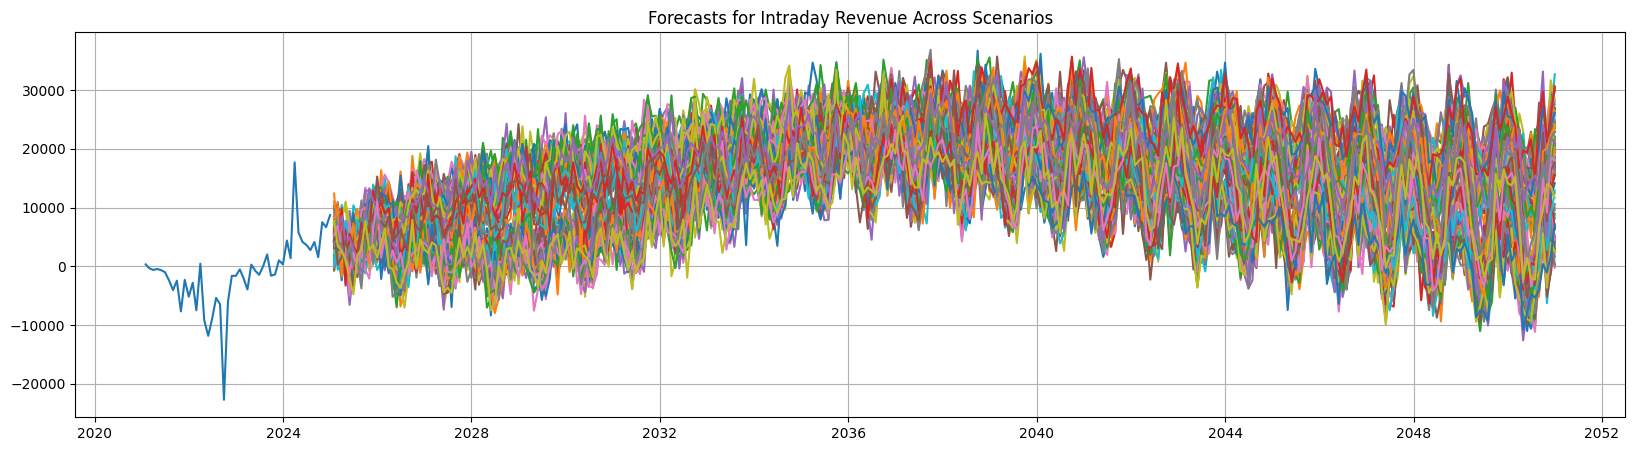

✅ Best Alpha: 22.229964825261934
✅ Mean Absolute Error on Full Data: 5503.9948


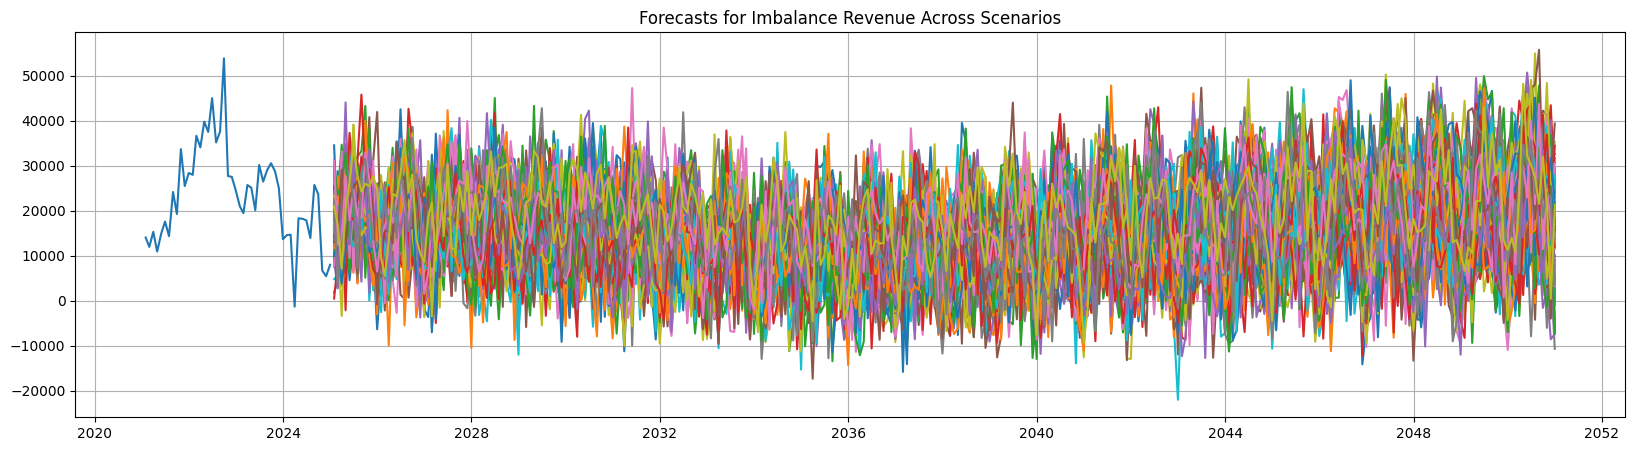

✅ Best Alpha: 0.9102981779915218
✅ Mean Absolute Error on Full Data: 138.2138


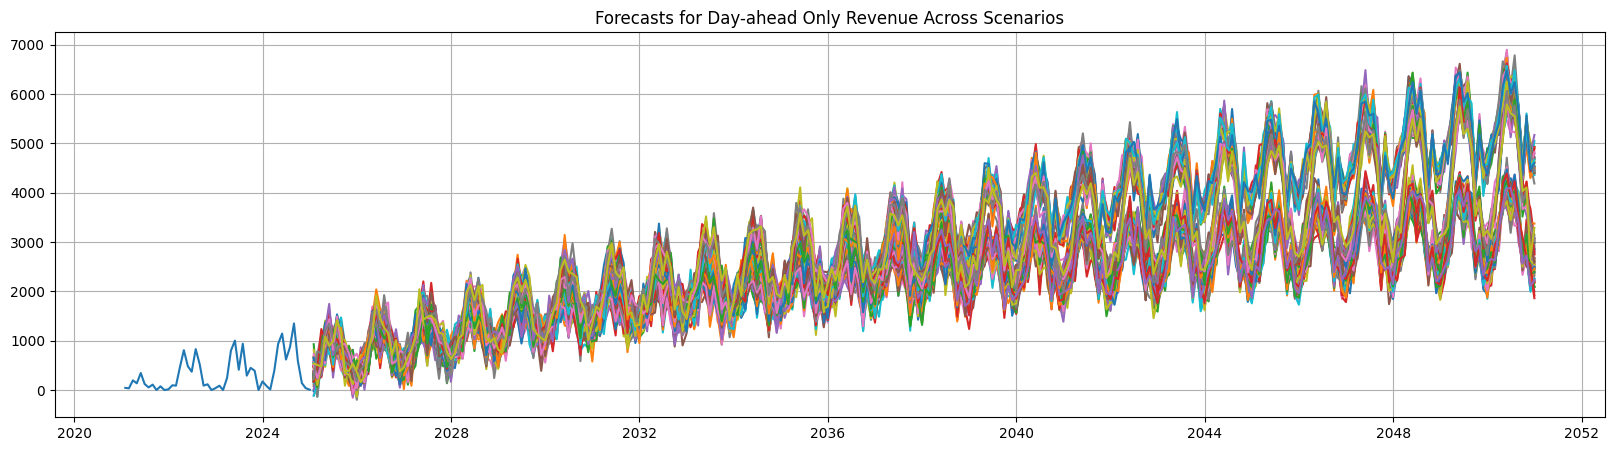

In [16]:
model, residuals, scaler = train_model(outcome="Intraday", show_summary=True, scale=False)
forecasts = forecast_with_scenarios(model, residuals, scaler, outcome="Intraday", add_volatility=True)
forecasts.to_csv("forecasts/intraday_revenue_forecasts_combined.csv")

model, residuals, scaler = train_model(outcome="Imbalance", show_summary=True)
forecasts = forecast_with_scenarios(model, residuals, scaler, outcome="Imbalance", add_volatility=True)
forecasts.to_csv("forecasts/imbalance_revenue_forecasts_combined.csv")

model, residuals, scaler = train_model(outcome="Day-ahead Only", show_summary=True)
forecasts = forecast_with_scenarios(model, residuals, scaler, outcome="Day-ahead Only", add_volatility=True)
forecasts.to_csv("forecasts/day_ahead_revenue_forecasts_combined.csv")

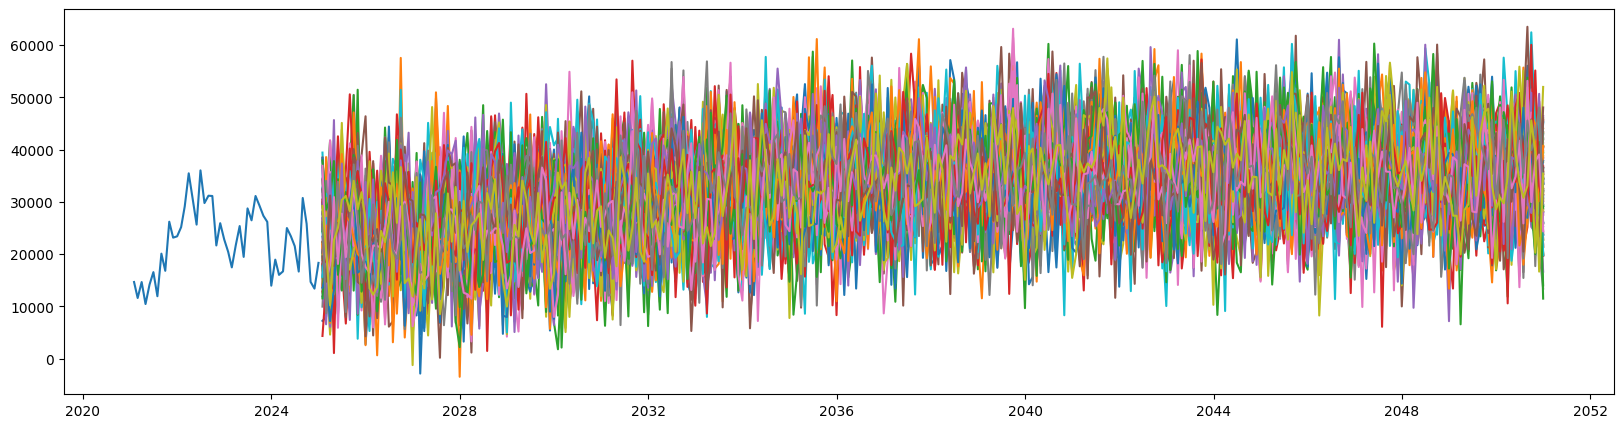

In [17]:
imbalance_revenue_forecasts = pd.read_csv("forecasts/imbalance_revenue_forecasts_combined.csv", parse_dates=["Date"])
imbalance_revenue_forecasts.set_index("Date", inplace=True)
day_ahead_revenue_forecasts = pd.read_csv("forecasts/day_ahead_revenue_forecasts_combined.csv", parse_dates=["Date"])
day_ahead_revenue_forecasts.set_index("Date", inplace=True)
intraday_revenue_forecasts = pd.read_csv("forecasts/intraday_revenue_forecasts_combined.csv", parse_dates=["Date"])
intraday_revenue_forecasts.set_index("Date", inplace=True)

total_revenue = pd.DataFrame(index = imbalance_revenue_forecasts.index, columns = day_ahead_revenue_forecasts.columns)
total_revenue.index.name = "Date"

for i in range(len(total_revenue.columns)):
    total_revenue.iloc[:, i] = imbalance_revenue_forecasts.iloc[:, i] + day_ahead_revenue_forecasts.iloc[:, i] + intraday_revenue_forecasts.iloc[:, i]

# Load historical dataset
historical_data = pd.read_csv("processed_data/historical_data.csv", parse_dates=["Date"])
historical_data.set_index("Date", inplace=True)

# Plot historical data
plt.figure(figsize=(20, 5))
plt.plot(historical_data.index, historical_data["Total"], label="Historical Revenue")

for column in total_revenue.columns:
    plt.plot(total_revenue.index, total_revenue[column], label=column)
plt.show()

total_revenue.to_csv("forecasts/total_revenue_summed_forecasts_combined.csv")

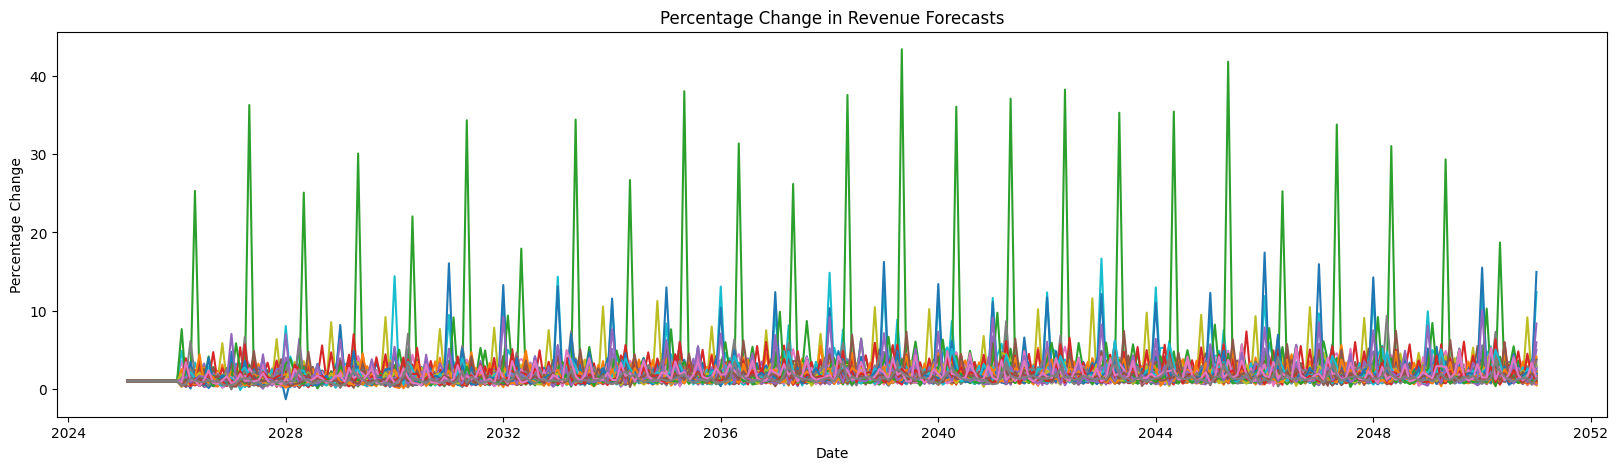

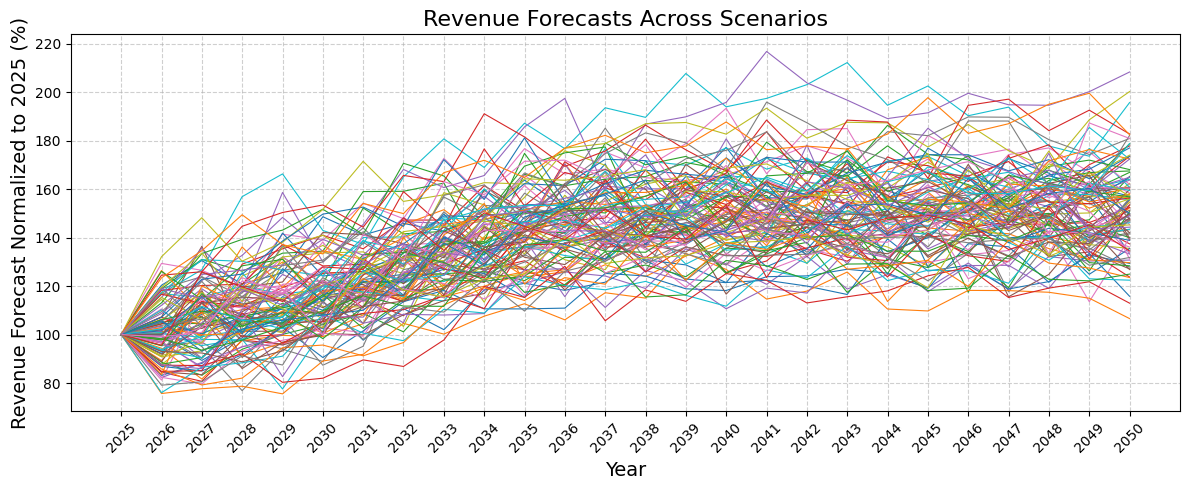

In [18]:
forecast_data = pd.read_csv("forecasts/total_revenue_summed_forecasts_combined.csv", parse_dates=["Date"])
forecast_data.set_index("Date", inplace=True)

monthly_reference = forecast_data.groupby(forecast_data.index.month).transform("first")
forecast_data_percentage = forecast_data / monthly_reference

# plot the percentage change for each scenario
plt.figure(figsize=(20, 5))
for column in forecast_data_percentage.columns:
    plt.plot(forecast_data_percentage.index, forecast_data_percentage[column], label=column)
plt.title("Percentage Change in Revenue Forecasts")
plt.xlabel("Date")
plt.ylabel("Percentage Change")
plt.show()

forecast_data_percentage.T.to_excel("forecasts/monthly_revenue_forecasts_percentage.xlsx", index=True, header=True)
forecast_data_percentage.to_csv("forecasts/monthly_revenue_forecasts_percentage.csv", index=True, header=True)

# Load the forecast dataset
forecast_data = pd.read_csv("forecasts/total_revenue_summed_forecasts_combined.csv", parse_dates=["Date"])
forecast_data.set_index("Date", inplace=True)

# Resample to yearly data using sum
yearly_revenue = forecast_data.resample('YE').sum()

# Convert the Date index to the year format
yearly_revenue.index = yearly_revenue.index.year

# Select the base year (2025)
base_year = yearly_revenue.iloc[0]
base_year_values = base_year.values

# Calculate percentage change compared to 2025
percentage_change = (yearly_revenue / base_year_values) * 100

# Reset index for easier viewing
percentage_change.reset_index(inplace=True)
percentage_change.rename(columns={"index": "Year"}, inplace=True)

# Save the result to a new CSV
percentage_change.to_csv("yearly_revenue_percentage_change.csv", index=False)
percentage_change.T.to_excel("yearly_revenue_percentage_change.xlsx", index=False)

# Load the data
forecast_data = pd.read_csv("yearly_revenue_percentage_change.csv", parse_dates=["Date"])
forecast_data.set_index("Date", inplace=True)

# Compute min and max across the selected scenarios at each time point
min_trend = forecast_data.min(axis=1)
max_trend = forecast_data.max(axis=1)

# Plot the original and random trends
plt.figure(figsize=(12, 5))
for column in forecast_data.columns:
    plt.plot(forecast_data.index, forecast_data[column], linewidth=0.8, label=column)

plt.xticks(forecast_data.index, forecast_data.index.year, rotation=45)
plt.title("Revenue Forecasts Across Scenarios", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Revenue Forecast Normalized to 2025 (%)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [21]:
# create share monthly
future_data = pd.read_csv("processed_data/future_data.csv", parse_dates=["Date"])
future_data.set_index("Date", inplace=True)

share_monthly = pd.DataFrame(index=future_data.index, columns=["A", "B", "C", "D", "E", "F"])

share_monthly["A"] = (future_data["Ba"] * 2) / future_data["Ra"]
share_monthly["B"] = (future_data["Bb"] * 2) / future_data["Rb"]
share_monthly["C"] = (future_data["Bc"] * 2) / future_data["Rc"]
share_monthly["D"] = (future_data["Bd"] * 2) / future_data["Rd"]
share_monthly["E"] = (future_data["Be"] * 2) / future_data["Re"]
share_monthly["F"] = (future_data["Bf"] * 2) / future_data["Rf"]

share_monthly

,A,B,C,D,E,F
Date,,,,,,
2025-01-31,0.012362,0.012362,0.011959,0.011959,0.011536,0.011536
2025-02-28,0.011858,0.011912,0.011238,0.010934,0.010407,0.010404
2025-03-31,0.011393,0.011496,0.010354,0.009791,0.009033,0.009028
2025-04-30,0.010443,0.010575,0.009236,0.008511,0.007712,0.007704
2025-05-31,0.010279,0.010444,0.008847,0.007951,0.007078,0.007069
...,...,...,...,...,...,...
2050-08-31,0.008987,0.009274,0.008336,0.005322,0.005996,0.006036
2050-09-30,0.010858,0.011477,0.010317,0.006450,0.007266,0.007531
2050-10-31,0.008765,0.010384,0.009335,0.005282,0.005951,0.007124
